{{ badge }}

In [22]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy

In [28]:
qubit_number = 4
qubits = range(qubit_number)

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


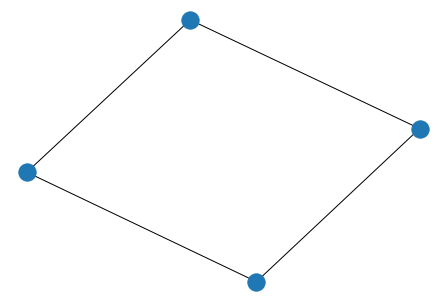

In [29]:
ising_graph = nx.cycle_graph(qubit_number)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

In [30]:
matrix_params = [[0.56, 1.24, 1.67, -0.79], [-1.44, -1.43, 1.18, -0.93, ]]

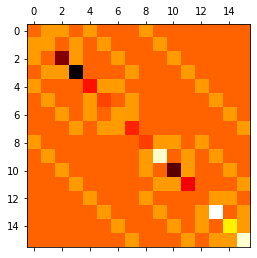

In [31]:
def create_hamiltonian_matrix(n, graph, params):

    matrix = np.zeros((2 ** n, 2 ** n))

    # Creates the interaction component of the Hamiltonian
    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if i[0] == j or i[1] == j:
                m = np.kron(m, qml.PauliZ.matrix)
            else:
                m = np.kron(m, np.identity(2))
        matrix += params[0][count] * m

    # Creates the bias components of the matrix
    for i in range(0, n):
        m1 = m2 = 1
        for j in range(0, n):
            if j == i:
                m1 = np.kron(m1, qml.PauliZ.matrix)
                m2 = np.kron(m2, qml.PauliX.matrix)
            else:
                m1 = np.kron(m1, np.identity(2))
                m2 = np.kron(m2, np.identity(2))
        matrix += (params[1][i] * m1 + m2)

    return matrix

# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, matrix_params)
plt.matshow(ham_matrix, cmap='hot')
plt.show()

In [32]:
# The collection of quantum data needed to run the QGRNN has two components: 
#   (i) copies of a low-energy state, and 
#   (ii) a collection of time-evolved states, each of which are simply the low-energy state evolved to different times. 
#   The following is a low-energy state of the target Hamiltonian

low_energy_state = [
    (-0.054661080280306085+0.016713907320174026j),
    (0.12290003656489545-0.03758500591109822j),
    (0.3649337966440005-0.11158863596657455j),
    (-0.8205175732627094+0.25093231967092877j),
    (0.010369790825776609-0.0031706387262686003j),
    (-0.02331544978544721+0.007129899300113728j),
    (-0.06923183949694546+0.0211684344103713j),
    (0.15566094863283836-0.04760201916285508j),
    (0.014520590919500158-0.004441887836078486j),
    (-0.032648113364535575+0.009988590222879195j),
    (-0.09694382811137187+0.02965579457620536j),
    (0.21796861485652747-0.06668776658411019j),
    (-0.0027547112135013247+0.0008426289322652901j),
    (0.006193695872468649-0.0018948418969390599j),
    (0.018391279795405405-0.005625722994009138j),
    (-0.041350974715649635+0.012650711602265649j)
    ]

In [33]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189114
Ground State Energy: -7.330689661291243


In [34]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j* hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

In [35]:
def qgrnn_layer(param1, param2, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for count, i in enumerate(graph.edges):
        qml.MultiRZ(2 * param1[count] * trotter_step, wires=[i[0], i[1]])

    # Applies a layer of RZ gates
    for count, i in enumerate(qubits):
        qml.RZ(2 * param2[count] * trotter_step, wires=i)

    # Applies a layer of RX gates
    for i in qubits:
        qml.RX(2 * trotter_step, wires=i)

In [36]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for i in range(0, len(register1)):
        qml.CSWAP(wires=[int(control), register1[i], register2[i]])
    qml.Hadamard(wires=control)

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


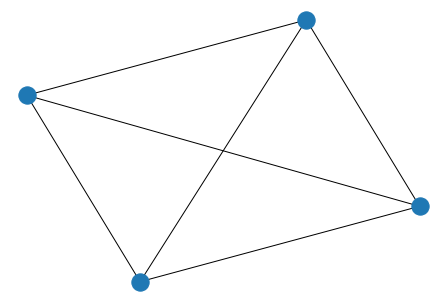

In [43]:

reg1 = list(range(qubit_number))  # First qubit register
reg2 = list(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.Graph()
new_ising_graph.add_nodes_from(range(qubit_number, 2 * qubit_number))
new_ising_graph.add_edges_from([(4, 5), (5, 6), (6, 7), (4, 6), (7, 4), (5, 7)])

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

In [44]:
def qgrnn(params1, params2, time=None):

    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state, low_energy_state), wires=reg1+reg2)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for i in range(0, int(depth)):
        qgrnn_layer(params1, params2, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)

    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

We have the full QGRNN circuit, but we still need to define a cost function.
# |⟨ψ(t)|UH(μ, Δ)|ψ0⟩|2 
approaches 1 as the states become more similar and approaches 0 as the states become orthogonal. Thus, we choose to minimize the quantity 
# −|⟨ψ(t)|UH(μ, Δ)|ψ0⟩|2L

Since we are interested in calculating this value for many different pieces of quantum data, the final cost function is the average negative fidelity* between registers:

# (μ,Δ)= −1NN∑i = 1 |⟨ψ(ti)| UH(μ, Δ) |ψ0⟩|2,

where we use 
N
 pieces of quantum data.

In [45]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

In [46]:
def cost_function(params):

    global iterations

    # Separates the parameter list
    weight_params = params[0:6]
    bias_params = params[6:10]

    # Randomly samples times at which the QGRNN runs
    times_sampled = [np.random.uniform() * max_time for i in range(0, N)]

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for i in times_sampled:
        result = qnode(weight_params, bias_params, time=i)
        total_cost += -1 * result

    # Prints the value of the cost function
    if iterations % 5 == 0:
        print(
            "Fidelity at Step " + str(iterations) + ": " + str((-1 * total_cost / N)._value)
            )
        print("Parameters at Step " + str(iterations) + ": " + str(params._value))
        print("---------------------------------------------")

    iterations += 1

    return total_cost / N

In [59]:
# Defines the new device

qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode

qnode = qml.QNode(qgrnn, qgrnn_dev)

iterations = 0
optimizer = qml.AdamOptimizer(stepsize=0.5)
steps = 300
qgrnn_params = list([np.random.randint(-20, 20)/50 for i in range(0, 10)])
init = copy.copy(qgrnn_params)

# Executes the optimization method

for i in range(0, steps):
    qgrnn_params = optimizer.step(cost_function, qgrnn_params)

Fidelity at Step 0: 0.9869562129760274
Parameters at Step 0: [0.36, -0.2, -0.26, 0.18, 0.28, 0.26, 0.12, 0.38, 0.22, -0.38]
---------------------------------------------
Fidelity at Step 5: 0.9818916782761892
Parameters at Step 5: [-1.1093141299702969, 1.2828706510122707, 1.0943788451621994, 1.7053256800494105, 1.5262123765611724, -1.0196326090582115, -1.3456651677231053, -1.1274883298539442, 1.76108895496494, 0.8171005665924622]
---------------------------------------------
Fidelity at Step 10: 0.9823613721175266
Parameters at Step 10: [-1.2639012874653088, 1.4803675987018743, 0.991804879181178, 2.034835251374648, 1.16336732306314, -0.7449493454083858, -1.489246149656205, -1.3997935813606033, 2.143096361274153, 0.3562994430866094]
---------------------------------------------
Fidelity at Step 15: 0.9979277043403635
Parameters at Step 15: [-0.8651078333119713, 1.1322643900821383, 0.4877258894566254, 1.855429017192701, 0.4151169324836854, -0.10266774417896828, -1.0789665262285346, -1.15

KeyboardInterrupt: 

With the learned parameters, we construct a visual representation of the Hamiltonian to which they correspond and compare it to the target Hamiltonian, and the initial guessed Hamiltonian:

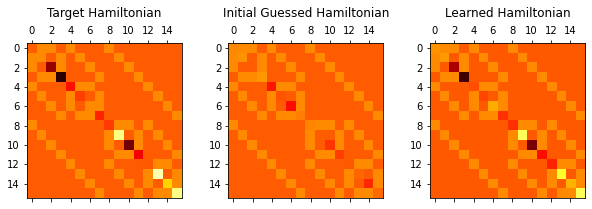

In [60]:
new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), [qgrnn_params[0:6], qgrnn_params[6:10]]
)

init_ham = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), [init[0:6], init[6:10]]
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap='hot')
axes[0].set_title("Target Hamiltonian", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap='hot')
axes[1].set_title("Initial Guessed Hamiltonian", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap='hot')
axes[2].set_title("Learned Hamiltonian", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [61]:
# and then remove them from the list of target parameters

qgrnn_params = list(qgrnn_params)

zero_weights = [qgrnn_params[1], qgrnn_params[4]]

del qgrnn_params[1]
del qgrnn_params[3]

In [62]:
#  print all of the weights

target_params = matrix_params[0] + matrix_params[1]

print(f"Target parameters: {target_params}")
print(f"Learned parameters: {qgrnn_params}")
print(f"Non-Existing Edge Parameters: {zero_weights}")

Target parameters: [0.56, 1.24, 1.67, -0.79, -1.44, -1.43, 1.18, -0.93]
Learned parameters: [0.2795935156975342, 1.334580365542125, 1.7004517023732753, -0.6117142387232278, -0.8472803814827449, -1.1954746465526613, 1.0555280598131738, -0.7363234199141969]
Non-Existing Edge Parameters: [0.252982970313843, -0.07799628630965101]


# References

Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., & Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint arXiv:1909.12264.